## Error Analysis

**Author:** Shaun Khoo  
**Date:** 4 Jan 2022  
**Context:** Model is performing decently, but need to identify where the model is struggling and see what we can do to improve performance  
**Objective:** Identify where the model is doing worse in, hypothesize why, and think of what we can do to improve this     

#### A) Importing libaries and data

In [114]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
import os
os.chdir('..')

In [160]:
test = pd.read_csv('Data/Train/Test.csv')
test['Predicted_SSOC_2020'] = test['Predicted_SSOC_2020'].astype('str')
with open('all_predictions_v2pt2_34ep.pickle', 'rb') as handle:
    test_predictions = pickle.load(handle)

In [217]:
test_MRSD = pd.read_csv('Data/Test_MRSD.csv')

#### B) Processing the predictions data

Here we convert the predictions into a Pandas dataframe.

In [161]:
df_output = []

for test_prediction in test_predictions:
    
    row_output = {}
    
    row_output['SSOC_4D_Top_Pred'] = test_prediction['SSOC_4D']['predicted_ssoc'][0]
    row_output['SSOC_4D_Top_5_Preds'] = ','.join(test_prediction['SSOC_4D']['predicted_ssoc'])
    row_output['SSOC_4D_Top_5_Preds_Correct'] = test_prediction['SSOC_4D']['accurate_prediction']

    row_output['SSOC_5D_Top_Pred'] = test_prediction['SSOC_5D']['predicted_ssoc'][0]
    row_output['SSOC_5D_Top_10_Preds'] = ','.join(test_prediction['SSOC_5D']['predicted_ssoc'])
    row_output['SSOC_5D_Top_10_Preds_Proba'] = ','.join([str(prob) for prob in test_prediction['SSOC_5D']['predicted_proba']])
    row_output['SSOC_5D_Top_10_Preds_Correct'] = test_prediction['SSOC_5D']['accurate_prediction']

    df_output.append(row_output)

Concatenate the dataframe together and add additional fields for error analysis

In [216]:
test_enhanced = pd.concat([test, pd.DataFrame(df_output)], axis = 1)
test_enhanced['SSOC_4D_Top_Pred_Correct'] = test_enhanced['Predicted_SSOC_2020'].str.slice(0, 4) == test_enhanced['SSOC_4D_Top_Pred']
test_enhanced['SSOC_5D_Top_Pred_Correct'] = test_enhanced['Predicted_SSOC_2020'] == test_enhanced['SSOC_5D_Top_Pred']
test_enhanced['SSOC_5D_Top_5_Preds_Correct'] = [ssoc in preds.split(',')[0:5] for ssoc, preds in zip(test_enhanced['Predicted_SSOC_2020'], test_enhanced['SSOC_5D_Top_10_Preds'])]

In [219]:
test_MRSD['model'] = 'mrsd'
test_enhanced['model'] = 'colab'

In [221]:
test_combined = pd.concat([test_enhanced, test_MRSD], axis = 0, ignore_index = True)

In [224]:
test_combined.drop(['SSOC_4D_Top_Pred', 'SSOC_4D_Top_5_Preds', 'SSOC_4D_Top_5_Preds_Correct', 'SSOC_5D_Top_10_Preds_Proba', 'SSOC_4D_Top_Pred_Correct'], axis = 1, inplace = True)

In [234]:
test_combined.to_csv('Data/Test_Combined.csv', index = False)

In [245]:
test_enhanced['SSOC_1D'] = test_enhanced['Predicted_SSOC_2020'].str.slice(0, 1)
test_enhanced['SSOC_2D'] = test_enhanced['Predicted_SSOC_2020'].str.slice(0, 2)

Add the SSOC title

In [227]:
with open('Deployments/lambda/dummy-api/ssoc_desc.json') as json_file:
    ssoc_desc = json.load(json_file)

In [232]:
test_combined['SSOC_Title'] = [ssoc_desc[ssoc]['title'] for ssoc in test_combined['Predicted_SSOC_2020'].astype('str')]
test_combined['SSOC_Description'] = [ssoc_desc[ssoc]['description'] for ssoc in test_combined['Predicted_SSOC_2020'].astype('str')]

#### C) Conducting error analysis

Check what the top-1 accuracy is for 5D SSOC

In [165]:
test_enhanced['SSOC_5D_Top_Pred_Correct'].value_counts(normalize=True)

True     0.587889
False    0.412111
Name: SSOC_5D_Top_Pred_Correct, dtype: float64

Check what the top-5 accuracy is for 5D SSOC

In [166]:
test_enhanced['SSOC_5D_Top_5_Preds_Correct'].value_counts(normalize=True)

True     0.893772
False    0.106228
Name: SSOC_5D_Top_5_Preds_Correct, dtype: float64

Check what the top-10 accuracy is for 5D SSOC

In [167]:
test_enhanced['SSOC_5D_Top_10_Preds_Correct'].value_counts(normalize=True)

True     0.942215
False    0.057785
Name: SSOC_5D_Top_10_Preds_Correct, dtype: float64

Plot a chart of number of samples vs accuracy

Plotting chart for number of samples vs top-10 accuracy

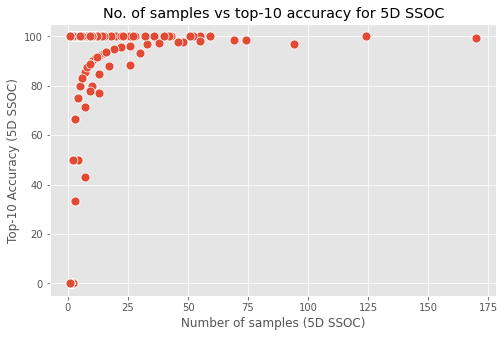

In [250]:
# Create a dataframe of accuracy and counts at the 5D level
SSOC_5D_error_analysis = test_enhanced.groupby('Predicted_SSOC_2020').agg(
    SSOC_5D_Correct_5DLevel = pd.NamedAgg(column = "SSOC_5D_Top_10_Preds_Correct", aggfunc = "sum"),
    SSOC_Title = pd.NamedAgg(column = "SSOC_Title", aggfunc = "min"),
    SSOC_1D = pd.NamedAgg(column = "SSOC_1D", aggfunc = "min"),
    Count = pd.NamedAgg(column = "SSOC_5D_Top_Pred_Correct", aggfunc = "count")
).reset_index()
SSOC_5D_error_analysis['Accuracy'] = round(SSOC_5D_error_analysis['SSOC_5D_Correct_5DLevel']/SSOC_5D_error_analysis['Count']*100, 1)

plt.figure(figsize = (8, 5))
plt.title('No. of samples vs top-10 accuracy for 5D SSOC')
plt.xlabel('Number of samples (5D SSOC)')
plt.ylabel('Top-10 Accuracy (5D SSOC)')
sns.scatterplot(x = 'Count',
                y = 'Accuracy',
                s = 80,
                data = SSOC_5D_error_analysis)
plt.savefig('Notebooks/Plots/NumSamples_Top10Accuracy_5DSSOC.png', dpi = 300)

We can see that model only struggles when number of samples < 20, and only does well when number of samples > 50. Data is a big constraint for this model.

In [213]:
np.mean(SSOC_5D_error_analysis[SSOC_5D_error_analysis['Count'] == 1]['Accuracy'])

58.088235294117645

Avg top-10 accuracy for SSOCs with only 1 observation is 58%.

In [170]:
SSOC_5D_error_analysis.sort_values(['Count', 'Accuracy'], ascending = False).tail(5)

,Predicted_SSOC_2020,SSOC_5D_Correct_5DLevel,SSOC_Title,SSOC_1D,Count,Accuracy
348,82139,0,Other quality checkers and testers,8,1,0.0
361,83423,0,Pile driver/Drilling machine operator,8,1,0.0
376,93337,0,Lashing worker,9,1,0.0
378,94102,0,Food/Drink stall assistant,9,1,0.0
380,96255,0,Sports and recreational attendant (e.g. golf m...,9,1,0.0


Examining top-10 SSOC accuracy by 1D SSOC to understand how different the accuracy is for different 1D SSOCs

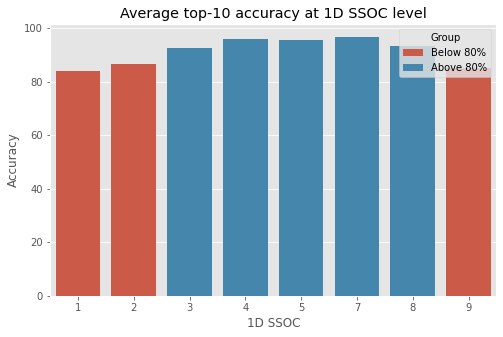

In [190]:
# Create a dataframe of accuracy and counts at the 1D level
SSOC_1D_error_analysis = SSOC_5D_error_analysis[(SSOC_5D_error_analysis['Count'] >= 2)].groupby('SSOC_1D').agg(
    Accuracy = pd.NamedAgg(column = "Accuracy", aggfunc = "mean"),
    Count = pd.NamedAgg(column = "Count", aggfunc = "sum")
).reset_index()
SSOC_1D_error_analysis['Group'] = SSOC_1D_error_analysis['Accuracy'].apply(lambda x: "Above 80%" if x >= 90 else "Below 80%")


plt.figure(figsize = (8, 5))
plt.title('Average top-10 accuracy at 1D SSOC level')
p = sns.barplot(x = 'SSOC_1D',
                y = 'Accuracy',
                hue = 'Group',
                dodge = False,
                #color = '#426cf5',
                data = SSOC_1D_error_analysis)
p.set(xlabel = '1D SSOC',
      label = 'Top-10 Accuracy (5D SSOC)')
plt.savefig('Notebooks/Plots/Top10Accuracy_by_1DSSOC.png', dpi = 300)

Subset the data to SSOCs beginning with '1' or '2', and do a 2D level analysis instead

C:\Users\shaun\AppData\Local\Temp/ipykernel_20420/2942951117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SSOC_5D_error_analysis_12['SSOC_2D'] = SSOC_5D_error_analysis_12['Predicted_SSOC_2020'].str.slice(0, 2)


[Text(0.5, 0, '1D SSOC'), None]

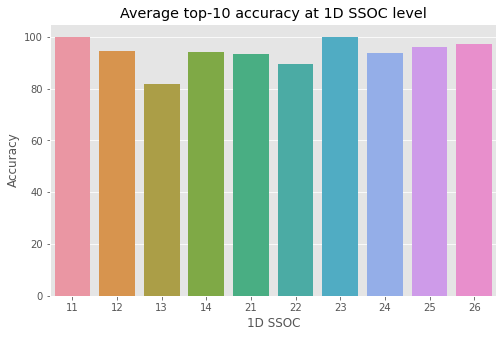

In [214]:
# Create a dataframe of accuracy and counts at the 1D level
SSOC_5D_error_analysis_12 = SSOC_5D_error_analysis[SSOC_5D_error_analysis['SSOC_1D'].isin(['1', '2']) & (SSOC_5D_error_analysis['Count'] >= 3)]
SSOC_5D_error_analysis_12['SSOC_2D'] = SSOC_5D_error_analysis_12['Predicted_SSOC_2020'].str.slice(0, 2)
SSOC_2D_error_analysis = SSOC_5D_error_analysis_12.groupby('SSOC_2D').agg(
    Accuracy = pd.NamedAgg(column = "Accuracy", aggfunc = "mean"),
    Count = pd.NamedAgg(column = "Count", aggfunc = "sum")
).reset_index()

plt.figure(figsize = (8, 5))
plt.title('Average top-10 accuracy at 1D SSOC level')
p = sns.barplot(x = 'SSOC_2D',
                y = 'Accuracy',
                data = SSOC_2D_error_analysis)
p.set(xlabel = '1D SSOC',
      label = 'Top-10 Accuracy (5D SSOC)')
#plt.savefig('Notebooks/Plots/Top10Accuracy_by_1DSSOC.png', dpi = 300)

Examining specific examples

In [203]:
test_enhanced[test_enhanced['SSOC_2D'] == '12']

,MCF_Job_Ad_ID,Predicted_SSOC_2020,title,description,SSOC_4D_Top_Pred,SSOC_4D_Top_5_Preds,SSOC_4D_Top_5_Preds_Correct,SSOC_5D_Top_Pred,SSOC_5D_Top_10_Preds,SSOC_5D_Top_10_Preds_Proba,SSOC_5D_Top_10_Preds_Correct,SSOC_4D_Top_Pred_Correct,SSOC_5D_Top_Pred_Correct,SSOC_5D_Top_5_Preds_Correct,SSOC_1D,SSOC_2D,SSOC_Title
3,MCF-2021-0090664,12133,Compliance Manager [FinTech / Risk Management ...,"Manage compliance risk strategies, policies an...",2413,"2413,2524,2611,3322,2412",False,26112,"26112,24132,26111,34110,13461,24121,24212,1221...","0.27128273,0.14566444,0.09715523,0.08572645,0....",True,False,False,False,1,12,Risk management manager
9,MCF-2020-0306138,12222,Marketing Manager - Performance & Growth,Own and manage.B2B and B2C marketing campaigns...,1222,"1222,3322,2431,1221,2421",True,12222,"12222,24314,33221,12212,33223,33225,33224,1221...","0.7081433,0.114039086,0.06353463,0.0360022,0.0...",True,True,True,True,1,12,Marketing manager
27,MCF-2021-0114497,12112,Finance and Administration Manager,Supporting day-to-day accounting and administr...,2411,"2411,4311,3313,1211,2423",True,24111,"24111,43112,33131,41101,12112,33132,24112,2423...","0.46214554,0.29564542,0.12191567,0.03631527,0....",True,False,False,True,1,12,Administration manager
29,MCF-2021-0121462,12212,Business Development Manager (IT/ Software),Maintaining current client relationships and i...,3322,"3322,1221,2421,2511,1330",True,12212,"12212,33221,24212,25113,12222,24121,25122,1330...","0.38518387,0.35233167,0.05918822,0.048510034,0...",True,False,True,True,1,12,Business development manager
44,MCF-2021-0119391,12123,TRAINING MANAGER,TRAINING MANAGER.Job Description.The candidate...,1212,"1212,2423,1211,3257,4110",True,12123,"12123,12112,24211,24213,13302,24231,24212,1222...","0.31472385,0.2012213,0.087188154,0.08350833,0....",True,True,True,True,1,12,Training manager
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,MCF-2021-0156353,12213,Regional Sales Manager,Provide customers with information regarding p...,3322,"3322,2433,1221,4224,1222",True,33221,"33221,12212,12222,24121,33222,33223,33224,2433...","0.32514414,0.20839125,0.07215289,0.06144116,0....",True,False,False,False,1,12,Regional sales manager
2845,MCF-2021-0093651,12222,Director of Marketing,Sign off on creative agencies and selection of...,1222,"1222,2432,2431,1221,1439",True,12222,"12222,24320,24314,14391,12212,33221,12221,1221...","0.40674883,0.13223468,0.10134425,0.060692318,0...",True,True,True,True,1,12,Marketing manager
2856,MCF-2021-0243579,12212,SALES / BUSINESS DEVELOPMENT MANAGER / ASSISTA...,"Our client, a local MNC in 3PL industry is see...",3322,"3322,1221,2433,2423,2511",True,33221,"33221,12212,24121,12222,33223,33222,33224,1221...","0.42208922,0.297855,0.06295963,0.049892277,0.0...",True,False,False,True,1,12,Business development manager
2864,MCF-2021-0051860,12113,Assistant Audit Manager [Central Area/ Up to $...,[Order Number: 2009-56290] [Responsibilities] ...,2411,"2411,3313,1211,4311,2515",True,24112,"24112,12113,24111,33132,43113,33131,25152,2413...","0.7351886,0.08942342,0.05526494,0.05368801,0.0...",True,False,False,True,1,12,Audit manager


Generating 2D level error analysis

In [9]:
SSOC_2D_error_analysis = test_enhanced.groupby('Predicted_SSOC_2020').agg(
    SSOC_5D_Correct_2DLevel = pd.NamedAgg(column = "SSOC_5D_Top_10_Preds_Correct", aggfunc = "sum"),
    Count = pd.NamedAgg(column = "SSOC_5D_Top_Pred_Correct", aggfunc = "count")
).reset_index()
SSOC_2D_error_analysis['Accuracy'] = round(SSOC_2D_error_analysis['SSOC_5D_Correct_2DLevel']/SSOC_2D_error_analysis['Count']*100, 1)

13: Production and specialised services managers  
26: Legal, social, religious, cultural professionals  
31: Engineering Associate Professionals  
32: Health Associate Professionals  
44: Other clerical support workers  
53: Personal care workers  
54: Protective service workers  
74: Electrical and electronic trades workers  
75: Food processing, woodworking, craft trades workers  
81: Plant machinery operators  
82: Assemblers and quality checkers  
91: Cleaners and helpers  
92: Agriculture and fishery workers  
96: Waste collection, recycling workers  

In [10]:
test[test['Predicted_SSOC_2020'] == '31122']

,MCF_Job_Ad_ID,Predicted_SSOC_2020,title,description
1005,MCF-2021-0234416,31122,Building Services Technician,Assist in developing scope of work for the pro...
1371,MCF-2021-0030852,31122,Technician [Building / Facilities / Woodlands]...,Job scopes: Building general maintenance work....
1382,MCF-2020-0345319,31122,Technician (Building),Roles & Responsibilities. Responsibilities: Ca...
1568,MCF-2021-0025954,31122,Technician / Senior Technician (Building & Fac...,Job Descriptions: Must have knowledge in comme...
1907,MCF-2021-0065737,31122,1723T-FACILITY TECHNICIANS (BUILDING & MAINTEN...,Woodlands Attractive Salary Career Progression...
2774,MCF-2021-0109042,31122,Building Technician,"Job Descriptions: Carrying out maintenance, re..."


Some observations:  
* Most of the SSOCs with low counts and 0 accuracy are in the 311 3D SSOC (Physical and Engineering Science Technicians)
* Business development executive is predicted more commonly than expected
* Technical sales consultant (24331) is too close to Electrical engineer (21511)
* Financial analyst (24131) is too close to Business consultant (24212)
* QA engineer (25151) is too close to Software developer (25121)
* Actuarial professionals (21239) is too close to Business consultant (24212)

In [151]:
test_enhanced[test['Predicted_SSOC_2020'] == '25220']

,MCF_Job_Ad_ID,Predicted_SSOC_2020,title,description,SSOC_4D_Top_Pred,SSOC_4D_Top_5_Preds,SSOC_4D_Top_5_Preds_Correct,SSOC_5D_Top_Pred,SSOC_5D_Top_10_Preds,SSOC_5D_Top_10_Preds_Correct,SSOC_4D_Top_Pred_Correct,SSOC_5D_Top_Pred_Correct,SSOC_2D
1335,MCF-2021-0158192,25220,Senior / Network Administrator (Ref: 2021-11...,Our next technology can start with You!Each of...,2523,"[2523, 2522, 3512, 2512, 2511]",True,25232,"[25232, 25241, 35123, 25121, 35121, 25211, 252...",False,False,False,25
1997,MCF-2020-0326451,25220,Computer System Administrator,"Job Responsibility: Installation, maintenance ...",3512,"[3512, 3511, 2523, 1330, 2512]",False,35123,"[35123, 25232, 35121, 36100, 35110, 25241, 252...",True,False,False,25
2298,MCF-2021-0185009,25220,IT Executive (System Network Administration),Core function is to support technology related...,2523,"[2523, 2522, 3512, 2512, 2511]",True,25232,"[25232, 35123, 25241, 25121, 35121, 25211, 252...",False,False,False,25
2775,MCF-2021-0152857,25220,System Network Administrator |Boon Keng - JYK,"Perform daily server monitoring, verifying the...",2523,"[2523, 3512, 2512, 2522, 2521]",True,25232,"[25232, 35123, 25241, 25121, 35121, 25211, 252...",False,False,False,25


In [154]:
test_enhanced[test_enhanced['Predicted_SSOC_2020'] == '33211']['SSOC_5D_Top_Pred'].value_counts()

24212    2
33221    1
Name: SSOC_5D_Top_Pred, dtype: int64

In [234]:
test[test['Predicted_SSOC_2020'] == '11203']

,MCF_Job_Ad_ID,title,description,Predicted_SSOC_2020
22,MCF-2020-0012755,Vice President - 19132341,<p>We are seeking Application Development Lead...,11203
202,MCF-2020-0096313,"Head, ServiceNow CoE",<p><strong>About Standard Chartered&nbsp;</str...,11203
412,MCF-2020-0233952,PMO Head,<ul>\n <li>Able to build and control the Prog...,11203
